## Studying unmasked cosmics

This uses the desimodel PSF from https://github.com/desihub/desimodel (code) and https://desi.lbl.gov/svn/code/desimodel/trunk (data)

In [1]:
import specter.extract
import desimodel.io
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/sbailey/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#- Inputs
psf = desimodel.io.load_psf('r')
nspec, nwave = 2, 30
ww = np.arange(6000, 6000+nwave)
photons = np.zeros((nspec, nwave))
photons[0,::10] = 100
photons[1,5::15] = 200

xyrange = psf.xyrange([0,nspec], ww)
truepix = psf.project(ww, photons, xyrange=xyrange)

rdnoise = 2
image = np.random.poisson(truepix) + np.random.normal(scale=rdnoise, size=truepix.shape)
ivar = 1.0/(truepix + rdnoise**2)

#- unmasked cosmic
cosmic_image = image.copy()
cosmic_image[20,8] = 40
cosmic_image[21,7] = 40

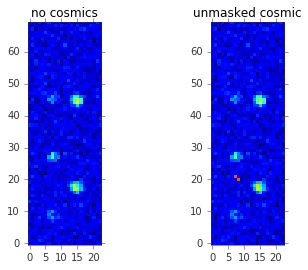

In [3]:
subplot(121); imshow(image, vmin=-5, vmax=50)
title('no cosmics')
subplot(122); imshow(cosmic_image, vmin=-5, vmax=50)
title('unmasked cosmic')

In [4]:
#- Perform extractions of each image
exa = specter.extract.ex2d(image, ivar, psf, 0, nspec, ww, xyrange=xyrange, full_output=True)
exb = specter.extract.ex2d(cosmic_image, ivar, psf, 0, nspec, ww, xyrange=xyrange, full_output=True)

/Users/sbailey/dev/specter/py/specter/extract/ex2d.py:184: RuntimeWarning: invalid value encountered in true_divide
  chi2x = (A.T.dot(chi.ravel()**2) / A.sum(axis=0)).reshape(subnspec, subnwave)


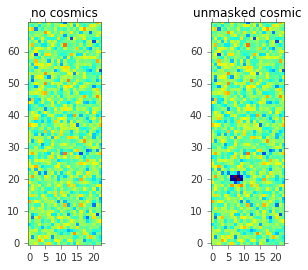

In [5]:
#- noise weighted residuals show blip around location of cosmic
chi_a = (image - exa['modelimage']) * np.sqrt(ivar)
chi_b = (cosmic_image - exb['modelimage']) * np.sqrt(ivar)

subplot(121); imshow(chi_a, vmin=-5, vmax=5)
title('no cosmics')
subplot(122); imshow(chi_b, vmin=-5, vmax=5)
title('unmasked cosmic')

In [6]:
#- Resolution convolved truth
from scipy.sparse import spdiags
offsets = np.arange(6, -7, -1)
truephot = np.zeros_like(photons)
for i in range(nspec):
    R = spdiags(exa['resolution_data'][i], offsets, nwave, nwave)
    truephot[i] = R.dot(photons[i])

phot_chia = (exa['flux'] - truephot) * np.sqrt(exa['ivar'])
phot_chib = (exb['flux'] - truephot) * np.sqrt(exb['ivar'])

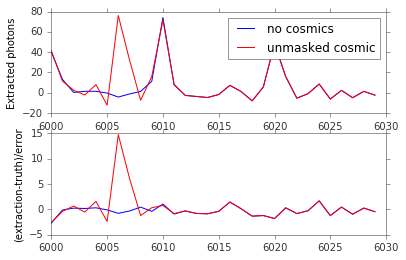

In [7]:
#- Extracted flux has big spike from cosmic around 6006 A
figure()
fig = subplot(211)
plot(ww, exa['flux'][0], 'b-', label='no cosmics')
plot(ww, exb['flux'][0], 'r-', label='unmasked cosmic')
ylabel('Extracted photons')
legend()
subplot(212)
plot(ww, phot_chia[0], 'b-')
plot(ww, phot_chib[0], 'r-')
ylabel('(extraction-truth)/error')

## chi2flux

In addition to the model image, specter calculates the PSF-weighted $\chi^2$ of the pixel model that contributes to the extraction for each flux bin:

$$
\Delta = (\mathrm{image} - \mathrm{model}) / \mathrm{sigma} \\
\mathrm{chi2flux} = {
    \sum_{pixels~i} P_i \Delta_i^2 \over \sum_{pixels~i} P_i}
$$

This is essentially a goodness of fit for each flux bin, and could be used after the extraction to flag questionable bins.

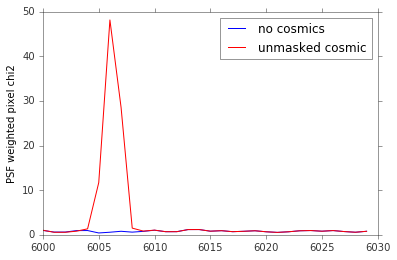

In [8]:
plot(ww, exa['chi2flux'][0], 'b-', label='no cosmics')
plot(ww, exb['chi2flux'][0], 'r-', label='unmasked cosmic')
ylabel('PSF weighted pixel chi2')
legend()